We test whether TDE can enhace prediction abilities of ESNs applied to the Lorenz System.

In [1]:
cd("$(homedir())/Documents/Repos/enso_project.jl")
using Pkg
Pkg.activate(".")

  Activating project at `C:\Users\lisah\Documents\Repos\enso_project.jl`


In [2]:
using ReservoirComputing, CSV, DataFrames, DynamicalSystems, Plots, enso_project

┌ Warning: Package cuDNN not found in current path.
│ - Run `import Pkg; Pkg.add("cuDNN")` to install the cuDNN package, then restart julia.
│ - If cuDNN is not installed, some Flux functionalities will not be available when running on the GPU.
└ @ FluxCUDAExt C:\Users\lisah\.julia\packages\Flux\9PibT\ext\FluxCUDAExt\FluxCUDAExt.jl:10


## Simulating Lorenz Data

In [3]:
# Set up the Lorenz system and generate data
lorenz = Systems.lorenz63()

# Integrate the system
T = 200.0
Δt = 0.1
Ttr = 100.0  # Transient that will be discarded

tr = trajectory(lorenz, T, Δt = Δt, Ttr = Ttr)
x, y, z = columns(tr[1])

# Put the data in the matrix format (n_features, n_samples) required by ReservoirComputing.jl 
data = copy(hcat(x, y, z)')

3×2001 Matrix{Float64}:
  -7.9554  -15.3466  -13.1091  -3.50536  …   2.60804   4.85809   9.20262
 -14.5316  -21.0154   -3.5192   3.71577      4.24185   7.98143  14.6799
  12.6248   30.0779   41.0784  30.7804      17.4522   15.3366   18.8447

In [4]:
l_max = lyapunov(lorenz, 100, Ttr = 100)

0.8986638632954478

## Tools

In [5]:
"""
    train_val_test_split(data; val_seconds, test_seconds, Δt = 0.1)

Split the given data into training, validation, and test sets.
"""
function train_val_test_split(data; val_seconds, test_seconds, Δt = 0.1)
    N = size(data, 2)
    N_val = round(Int, val_seconds / Δt)
    N_test = round(Int, test_seconds / Δt)
    
    ind1 = N - N_test - N_val
    ind2 = N - N_test
    
    train_data = data[:, 1:ind1]
    val_data = data[:, ind1+1:ind2]
    test_data = data[:, ind2+1:end]
    
    return train_data, val_data, test_data
end

train_val_test_split

In [6]:
"""
    plot_prediction(esn, Wₒᵤₜ, test_data, λ_max)

Given an Echo State Network, plot its predictions versus the given test set.
"""
function plot_prediction(esn, Wₒᵤₜ, test_data, λ_max, title)
    steps_to_predict = size(test_data, 2)
    prediction = esn(Generative(steps_to_predict), Wₒᵤₜ)
    
    label = ["actual" "predicted"]
    times = Δt * collect(0:steps_to_predict)[1:end-1] / λ_max

    plot(times, [test_data[1, :], prediction[1, :]], label = label, ylabel = "trajectory" , xlabel = "t * λ_max", title = title)
end

plot_prediction

## One observable

In [7]:
# set up hyperparameters for grid search
spectral_radii = [0.8, 0.9, 1.0]
sparsities = [0.05, 0.08, 0.1, 0.12, 0.14]
input_scales = [0.1, 0.5, 1.0, 2.0]
ridge_values = [0.0, 1e-6, 1e-5]
reservoir_sizes = [140,150, 155, 160, 165, 170, 180, 190, 200, 210, 220, 230]

param_grid_x = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values);


### ESN training on x observable with TDE

In [12]:
# perform TDE on x_data 
x_data_emb, τ, E = optimal_separated_de(data[1,:])

Algorithm stopped due to convergence of E₁-statistic. Valid embedding achieved ✓.


(3-dimensional StateSpaceSet{Float64} with 1997 points, 2, [0.002038403486061745, 0.23444505829574647, 0.871363371003479, 0.9166960333351355, 0.9509470839624319, 0.9908498508057381, 0.9828200036868323, 0.9842194413340516, 0.9738364004512658, 0.9908072010040886])

In [13]:
train_x_data_emb, val_x_data_emb, test_x_data_emb = train_val_test_split(Matrix(x_data_emb)'; val_seconds= 15* l_max, test_seconds =15* l_max)

([-7.9554025169651865 -15.346598018787718 … -9.611377124950293 -14.149548893578913; -13.109135464327167 -3.5053643451828465 … -10.638861349658093 -4.332534432311105; 0.9935214182501073 2.8950872524314937 … -1.6450552437632642 -1.252438550207344], [-10.638861349658093 -4.332534432311105 … -13.477984779336781 -13.21770933483036; -1.6450552437632642 -1.252438550207344 … -5.790194667320335 -1.505872934191586; -1.9915260176863208 -4.146410742024305 … -0.2577451509593099 0.03457128227357564], [-5.790194667320335 -1.505872934191586 … -11.024914402851575 -2.524607876341493; -0.2577451509593099 0.03457128227357564 … 0.9892525790247507 2.608036944861364; 0.16910303684286143 0.41166202632325727 … 4.858086000161583 9.202624020981212])

In [14]:
esn_x_emb, W_out_x_emb, val_loss_x_emb = enso_project.cross_validate_esn(train_x_data_emb, val_x_data_emb, param_grid_x)

enso_project.ESNHyperparams(140, 0.8, 0.05, 0.1, 0.0)
Validation loss = 24739.564746338983
enso_project.ESNHyperparams(170, 0.8, 0.05, 0.1, 0.0)
Validation loss = 22992.450110774007
enso_project.ESNHyperparams(220, 0.8, 0.05, 0.1, 0.0)
Validation loss = 21555.142895610526
enso_project.ESNHyperparams(150, 0.8, 0.08, 0.1, 0.0)
Validation loss = 17384.634405069373
enso_project.ESNHyperparams(180, 0.9, 0.08, 0.1, 0.0)
Validation loss = 11170.665885168371
enso_project.ESNHyperparams(180, 0.9, 0.08, 0.1, 1.0e-6)
Validation loss = 7692.185165825643


(ESN(3 => 180), OutputLayer successfully trained with output size: 3, 7692.185165825643)

### ESN training on x observable without TDE

In [15]:
x_data_1D = data[1,1:length(x_data_emb)]
train_x_data_1D, val_x_data_1D, test_x_data_1D = train_val_test_split(Matrix(x_data_1D'); val_seconds= 15* l_max, test_seconds =15* l_max)

([-7.9554025169651865 -15.346598018787718 … -9.611377124950293 -14.149548893578913], [-10.638861349658093 -4.332534432311105 … -13.477984779336781 -13.21770933483036], [-5.790194667320335 -1.505872934191586 … -11.024914402851575 -2.524607876341493])

In [16]:
# network training
esn_x_1D, W_out_x_1D, val_loss_x_1D = enso_project.cross_validate_esn(train_x_data_1D, val_x_data_1D, param_grid_x)

enso_project.ESNHyperparams(140, 0.8, 0.05, 0.1, 0.0)
Validation loss = 18254.093579742777
enso_project.ESNHyperparams(150, 0.8, 0.05, 0.1, 0.0)
Validation loss = 15175.943442807838
enso_project.ESNHyperparams(155, 0.8, 0.05, 0.1, 0.0)
Validation loss = 15131.928950412512
enso_project.ESNHyperparams(200, 0.8, 0.05, 0.1, 0.0)
Validation loss = 4355.147805564407
enso_project.ESNHyperparams(190, 0.8, 0.1, 0.1, 0.0)
Validation loss = 3498.5595193726667
enso_project.ESNHyperparams(200, 0.8, 0.1, 0.1, 0.0)
Validation loss = 2491.1308395940973
enso_project.ESNHyperparams(150, 0.8, 0.1, 0.1, 1.0e-5)
Validation loss = 1581.38291968295


(ESN(1 => 150), OutputLayer successfully trained with output size: 1, 1581.38291968295)

### Comparison

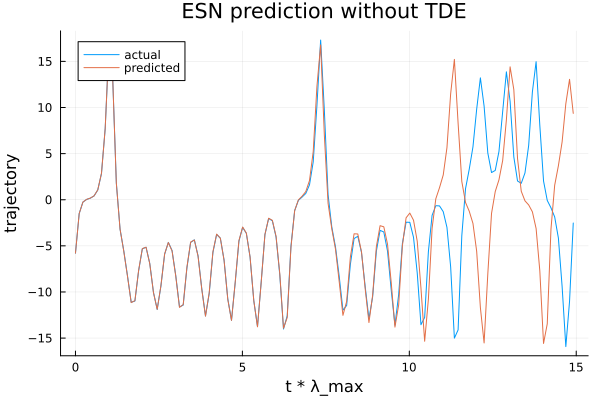

In [17]:
plot_prediction(esn_x_1D, W_out_x_1D, test_x_data_1D, l_max, "ESN prediction without TDE")

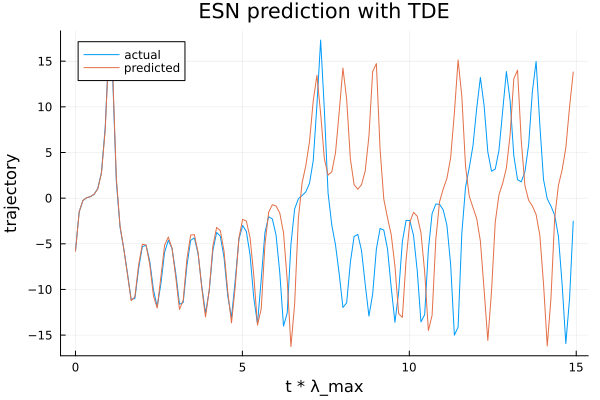

In [23]:
plot_prediction(esn_x_emb, W_out_x_emb, test_x_data_1D, l_max, "ESN prediction with TDE")

The prediction without TDE is seemingly better.